# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy

### Task: Predict what the student is going to code next.

Input: For each of the N students, we have a time series of Abstract Syntax Trees (ASTs), which represent the student's code at that time step.
- input shape (num_students, num_timesteps, num_asts)
    - num_timesteps is the max sequence length of asts that we are taking into account.
    - num_asts is the total number of asts for that problem.

Output: At each timestep, we are predicting the next AST.
- Output shape (num_students, num_timesteps, num_asts). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_students, num_timesteps) Values are in range (0, num_asts)

Accuracy:
- Raw Accuracy: For all predictions at all timesteps, we get the percentage of predictions we got correct.
- Corrected Accuracy: Since many trajectories contain fewer asts than max_traj_len, we fill the empty asts with our dummy ast token at row 0. However, predicting on end tokens is to simple of a task and might bias our results. The corrected accuracy ignores all predictions on the end token.

### Current Issues:
AST IDs are not consistent across different HOCs. Hence, we can only train and run this model on each HOC individually.


In [32]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
from pprint import pprint
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Import our own modules
import utils
import model_predict_ast as model
import visualize
from constants import *

In [35]:
# hyperparameters
hidden_size = 256 # size of hidden layer of neurons
learning_rate = 5e-3
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 16
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [38]:
def full_train_test_run(hoc_num, data_sz=-1):
    X, y, ast_maps, num_asts = utils.load_dataset_predict_ast_using_embeddings(hoc_num=HOC_NUM, data_sz=DATA_SZ)
    num_traj, num_timesteps, embed_dim = X.shape

    X_train = X[0:7*num_traj/8]
    X_val =  X[7*num_traj/8: 15*num_traj/16 ]
    X_test = X[15*num_traj/16:num_traj]

    y_train = y[0:7*num_traj/8]
    y_val =  y[7*num_traj/8: 15*num_traj/16]
    y_test = y[15*num_traj/16:num_traj]

    train_data = X_train, y_train
    val_data = X_val, y_val
    test_data = X_test, y_test
    # create model
    train_loss_acc, compute_loss_acc, probs, l_out = model.create_model(num_timesteps, num_asts, hidden_size, learning_rate, embed_dim, grad_clip, dropout_p, num_lstm_layers)
    # Training!
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)
    # Evaluate on test set
    test_loss, test_raw_acc, test_corrected_acc, test_corrected_acc_per_timestep, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test', compute_acc_per_timestep_bool=True)
 
    num_train = train_data[0].shape[0]
    visualize.plot_loss_acc('hoc'+ str(hoc_num) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')  
    return train_corrected_accs[-1], val_corrected_accs[-1], test_corrected_acc_per_timestep

Training and testing predict_next_ast rnn on Hour of Code problem #1
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '19865' (I am process '19563')



Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.61944, train acc 0.00, train corr acc 0.00, val acc 65.97, val corr acc 37.05
Ep 0 	iter 2  	loss 7.45118, train acc 56.88, train corr acc 30.30, val acc 65.84, val corr acc 36.81
Ep 0 	iter 3  	loss 6.99722, train acc 60.00, train corr acc 33.33, val acc 65.87, val corr acc 36.86
Ep 0 	iter 4  	loss 6.08132, train acc 65.00, train corr acc 35.63, val acc 65.95, val corr acc 37.00
Ep 0 	iter 5  	loss 4.69016, train acc 65.00, train corr acc 35.63, val acc 65.97, val corr acc 37.05
Ep 0 	iter 6  	loss 3.44530, train acc 62.50, train corr acc 35.48, val acc 65.90, val corr acc 36.91
Ep 0 	iter 7  	loss 2.67692, train acc 65.00, train corr acc 36.36, val acc 65.90, val corr acc 36.91
Ep 0 	iter 8  	loss 1.95591, train acc 70.00, train corr acc 40.00, val acc 65.90, val corr acc 36.91
Ep 0 	iter 9  	loss 2.12088, train acc 67.50, train corr acc 38.10, val acc 65.90, val corr acc 36.91
Ep 0 	iter 10 

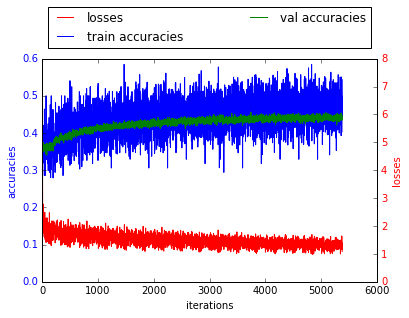

Training and testing predict_next_ast rnn on Hour of Code problem #2
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.63612, train acc 0.00, train corr acc 0.00, val acc 63.04, val corr acc 32.75
Ep 0 	iter 2  	loss 7.46193, train acc 62.50, train corr acc 34.07, val acc 64.86, val corr acc 36.06
Ep 0 	iter 3  	loss 7.11915, train acc 65.00, train corr acc 37.08, val acc 64.91, val corr acc 36.15
Ep 0 	iter 4  	loss 6.29814, train acc 71.88, train corr acc 43.04, val acc 65.22, val corr acc 36.72
Ep 0 	iter 5  	loss 5.09849, train acc 66.25, train corr acc 37.21, val acc 64.99, val corr acc 36.29
Ep 0 	iter 6  	loss 3.69462, train acc 63.12, train corr acc 37.23, val acc 65.17, val corr acc 36.63
Ep 0 	iter 7  	loss 2.60475, train acc 69.38, trai

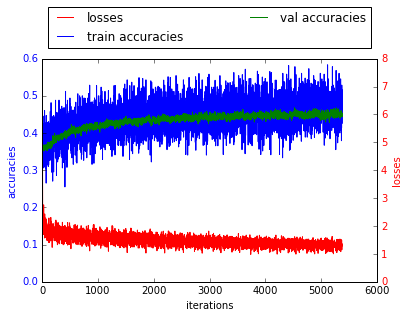

Training and testing predict_next_ast rnn on Hour of Code problem #3
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.62219, train acc 0.00, train corr acc 0.00, val acc 65.92, val corr acc 37.43
Ep 0 	iter 2  	loss 7.45222, train acc 60.62, train corr acc 33.68, val acc 65.51, val corr acc 36.67
Ep 0 	iter 3  	loss 7.01505, train acc 63.12, train corr acc 34.44, val acc 65.32, val corr acc 36.34
Ep 0 	iter 4  	loss 6.10125, train acc 63.12, train corr acc 35.16, val acc 65.66, val corr acc 36.96
Ep 0 	iter 5  	loss 4.78271, train acc 61.88, train corr acc 34.41, val acc 65.43, val corr acc 36.53
Ep 0 	iter 6  	loss 3.30390, train acc 73.12, train corr acc 42.67, val acc 65.53, val corr acc 36.72
Ep 0 	iter 7  	loss 2.35293, train acc 66.88, trai

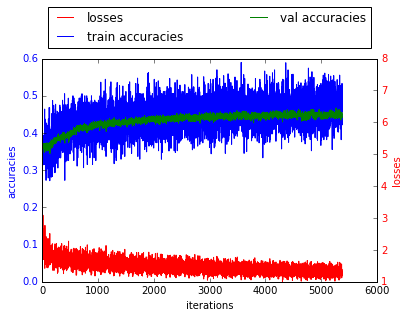

Training and testing predict_next_ast rnn on Hour of Code problem #4
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.62093, train acc 0.00, train corr acc 0.00, val acc 64.44, val corr acc 35.42
Ep 0 	iter 2  	loss 7.43550, train acc 65.00, train corr acc 37.78, val acc 64.78, val corr acc 36.04
Ep 0 	iter 3  	loss 6.98707, train acc 60.62, train corr acc 31.52, val acc 64.83, val corr acc 36.13
Ep 0 	iter 4  	loss 6.04662, train acc 61.25, train corr acc 33.33, val acc 64.60, val corr acc 35.71
Ep 0 	iter 5  	loss 4.62554, train acc 66.25, train corr acc 35.71, val acc 64.78, val corr acc 36.04
Ep 0 	iter 6  	loss 3.36996, train acc 58.75, train corr acc 33.33, val acc 64.75, val corr acc 35.99
Ep 0 	iter 7  	loss 2.49507, train acc 68.12, trai

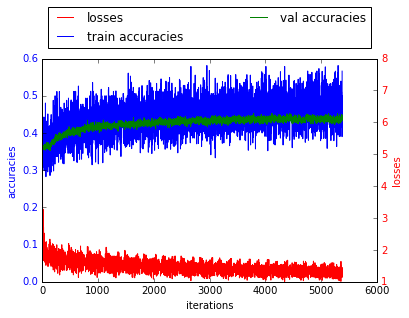

Training and testing predict_next_ast rnn on Hour of Code problem #5
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.62152, train acc 0.00, train corr acc 0.00, val acc 64.78, val corr acc 35.92
Ep 0 	iter 2  	loss 7.45047, train acc 62.50, train corr acc 31.82, val acc 64.83, val corr acc 36.01
Ep 0 	iter 3  	loss 7.01641, train acc 61.88, train corr acc 34.41, val acc 65.14, val corr acc 36.58
Ep 0 	iter 4  	loss 6.06059, train acc 64.38, train corr acc 35.96, val acc 64.96, val corr acc 36.25
Ep 0 	iter 5  	loss 4.62710, train acc 60.62, train corr acc 33.68, val acc 65.04, val corr acc 36.39
Ep 0 	iter 6  	loss 3.30929, train acc 65.62, train corr acc 38.20, val acc 65.01, val corr acc 36.34
Ep 0 	iter 7  	loss 2.73139, train acc 60.00, trai

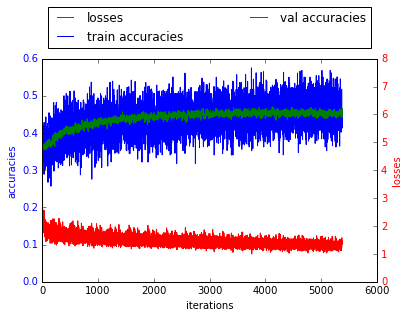

Training and testing predict_next_ast rnn on Hour of Code problem #6
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.61365, train acc 0.00, train corr acc 0.00, val acc 65.95, val corr acc 36.97
Ep 0 	iter 2  	loss 7.40884, train acc 65.62, train corr acc 36.05, val acc 65.97, val corr acc 37.02
Ep 0 	iter 3  	loss 6.98578, train acc 63.12, train corr acc 34.44, val acc 65.90, val corr acc 36.88
Ep 0 	iter 4  	loss 5.89323, train acc 67.50, train corr acc 37.35, val acc 66.18, val corr acc 37.40
Ep 0 	iter 5  	loss 4.44961, train acc 65.62, train corr acc 35.29, val acc 66.23, val corr acc 37.50
Ep 0 	iter 6  	loss 3.03112, train acc 65.00, train corr acc 37.08, val acc 65.95, val corr acc 36.97
Ep 0 	iter 7  	loss 2.34674, train acc 69.38, trai

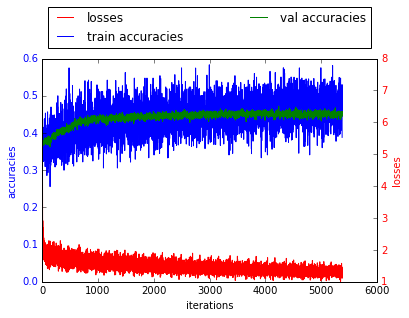

Training and testing predict_next_ast rnn on Hour of Code problem #7
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.61641, train acc 0.00, train corr acc 0.00, val acc 65.64, val corr acc 36.67
Ep 0 	iter 2  	loss 7.43012, train acc 63.12, train corr acc 35.87, val acc 65.58, val corr acc 36.57
Ep 0 	iter 3  	loss 6.89905, train acc 63.75, train corr acc 36.26, val acc 65.53, val corr acc 36.48
Ep 0 	iter 4  	loss 5.87829, train acc 60.00, train corr acc 31.91, val acc 65.66, val corr acc 36.72
Ep 0 	iter 5  	loss 4.30323, train acc 68.12, train corr acc 38.55, val acc 65.71, val corr acc 36.81
Ep 0 	iter 6  	loss 3.16856, train acc 61.88, train corr acc 35.11, val acc 65.69, val corr acc 36.76
Ep 0 	iter 7  	loss 2.41608, train acc 65.62, trai

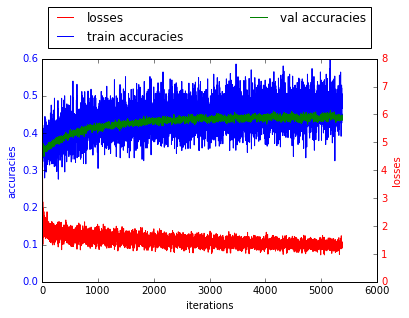

Training and testing predict_next_ast rnn on Hour of Code problem #8
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.61796, train acc 0.00, train corr acc 0.00, val acc 65.66, val corr acc 36.81
Ep 0 	iter 2  	loss 7.40995, train acc 60.00, train corr acc 33.33, val acc 65.66, val corr acc 36.81
Ep 0 	iter 3  	loss 6.95020, train acc 68.12, train corr acc 38.55, val acc 66.00, val corr acc 37.43
Ep 0 	iter 4  	loss 5.99681, train acc 66.88, train corr acc 36.90, val acc 65.82, val corr acc 37.09
Ep 0 	iter 5  	loss 4.39845, train acc 70.00, train corr acc 40.74, val acc 65.74, val corr acc 36.95
Ep 0 	iter 6  	loss 3.35146, train acc 65.00, train corr acc 34.88, val acc 65.64, val corr acc 36.76
Ep 0 	iter 7  	loss 2.64201, train acc 59.38, trai

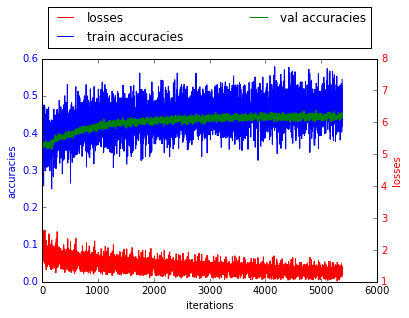

Training and testing predict_next_ast rnn on Hour of Code problem #9
Preparing network inputs and targets, and the ast maps...
Trajectory matrix shape (12324, 6, 2042)
2042
50321
Inputs and targets done!
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!
Starting training...
Total training iterations: 5376
Ep 0 	iter 1  	loss 7.61682, train acc 0.00, train corr acc 0.00, val acc 65.92, val corr acc 36.95
Ep 0 	iter 2  	loss 7.43211, train acc 69.38, train corr acc 39.51, val acc 65.90, val corr acc 36.91
Ep 0 	iter 3  	loss 6.94688, train acc 68.12, train corr acc 38.55, val acc 65.90, val corr acc 36.91
Ep 0 	iter 4  	loss 5.89094, train acc 65.62, train corr acc 36.78, val acc 65.82, val corr acc 36.76
Ep 0 	iter 5  	loss 4.32432, train acc 67.50, train corr acc 38.10, val acc 65.92, val corr acc 36.95
Ep 0 	iter 6  	loss 3.01920, train acc 66.88, train corr acc 36.14, val acc 65.92, val corr acc 36.95
Ep 0 	iter 7  	loss 2.37500, train acc 63.12, trai

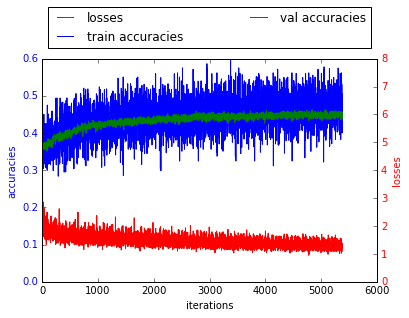

In [39]:
last_train_corrected_acc = {}
last_val_corrected_acc = {}
test_corrected_acc_per_timestep = {}

for hoc_num in xrange(HOC_MIN, HOC_MAX + 1):
    print ('Training and testing predict_next_ast rnn on Hour of Code problem #{}'.format(hoc_num))
    last_train_corrected_acc[hoc_num], last_val_corrected_acc[hoc_num], test_corrected_acc_per_timestep[hoc_num] = full_train_test_run(hoc_num) 
    print ('='*100)


In [40]:
for hoc_num in xrange(HOC_MIN, HOC_MAX + 1):
    print ('last train acc: {:.2f} %'.format(last_train_corrected_acc[hoc_num] * 100))
    print ('last val acc: {:.2f} %'.format(last_val_corrected_acc[hoc_num] * 100))
    print ('test accs time series: {}'.format(test_corrected_acc_per_timestep[hoc_num]))

last train acc: 47.50 %
last val acc: 44.31 %
test accs time series: [0.0933852140077821, 0.4523121387283237, 0.8280254777070064, 0.9246575342465754, 0.875]
last train acc: 48.86 %
last val acc: 45.18 %
test accs time series: [0.11413748378728923, 0.4460227272727273, 0.7840670859538784, 0.9487179487179487, 0.9166666666666666]
last train acc: 44.58 %
last val acc: 44.59 %
test accs time series: [0.0946822308690013, 0.46099290780141844, 0.8191489361702128, 0.9315068493150684, 1.0]
last train acc: 56.63 %
last val acc: 43.35 %
test accs time series: [0.10894941634241245, 0.4510086455331412, 0.7969432314410481, 0.9230769230769231, 0.9259259259259259]
last train acc: 43.48 %
last val acc: 44.61 %
test accs time series: [0.11932555123216602, 0.4755043227665706, 0.8251121076233184, 0.916083916083916, 1.0]
last train acc: 38.82 %
last val acc: 45.77 %
test accs time series: [0.11673151750972763, 0.47503566333808844, 0.8131868131868132, 0.9178082191780822, 0.9166666666666666]
last train acc: 46